# IVE face recognition project

In this project...

## STEP 1: Load the images and process data

### 1.1 Retrieve the paths of the imagenes from the SQLite DB

In [10]:
import sqlite3

## Connect Python with the created DB

conn = sqlite3.connect('images.db')
cursor = conn.cursor()

## Retrieve the paths and labels

cursor.execute('SELECT file_path, label FROM images')
data = cursor.fetchall() # This part creates a List of tuples that contains (file_path, label)

cursor.execute("SELECT DISTINCT label FROM images")
unique_labels = [row[0] for row in cursor.fetchall()]
print(unique_labels)
print('vs')
print('Original query random index: ', data[45]) # There are different members in the dataset, the insertion worked properly

conn.close()

## Make separate lists

images_paths, labels = zip(*data)

['Gaeul', 'Leeseo', 'Liz', 'Rei', 'Wonyoung', 'Yujin']
vs
Original query random index:  ('C:\\Users\\lonel\\OneDrive\\Escritorio\\IVE face recognition\\Leeseo\\Le13.jpg', 'Leeseo')


### 1.2 Load images using OpenCV

In [11]:
import cv2

## Comprove if the filepaths are correct:

img = cv2.imread(images_paths[0]) # Load the first image
cv2.imshow('First image:', img) # Display the first image

cv2.waitKey(0)
cv2.destroyAllWindows() # All correct

### 1.3 Resizing & Normalization

The machine learning model will need that all the images are the same size so we are going to preprocess the images in the next code.

In [12]:
import numpy as np

## Define the size

img_size = (224, 224)

## Preprocess the images

def preprocess_image(img_path):
    img = cv2.imread(img_path) # Load images
    img = cv2.resize(img, img_size) # Resize tthe images
    img = img.astype('float32') / 255 # Normalize pixel values; pixel values scaled to [0,1] for better training performance

    return img

## Apply to all the images

processed_images = np.array([preprocess_image(path) for path in images_paths])

print('Shape of images', processed_images.shape)

Shape of images (198, 224, 224, 3)


### 1.4 Encode labels for model training

In [13]:
from sklearn.preprocessing import LabelEncoder

## Convert text labels to numbers

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

## See the result

print('Original labels: ', labels[:6]) # It worked properly
print('Encoded labels: ', encoded_labels[:6])

print('Another index of the labes: ', labels[80])
print('Another index of the encoded labes: ', encoded_labels[80])

## Assure that all the members were correctly encoded

print('Labels unique values: ', np.unique(labels))
print('Encoded labels unique values: ', np.unique(encoded_labels))

Original labels:  ('Gaeul', 'Gaeul', 'Gaeul', 'Gaeul', 'Gaeul', 'Gaeul')
Encoded labels:  [0 0 0 0 0 0]
Another index of the labes:  Liz
Another index of the encoded labes:  2
Labels unique values:  ['Gaeul' 'Leeseo' 'Liz' 'Rei' 'Wonyoung' 'Yujin']
Encoded labels unique values:  [0 1 2 3 4 5]


## 2. Extract Features Using PCA

### 2.1 Convert the images into numeric data

In [14]:
## Convert the np array with images into 1D array

N = processed_images.shape[0] # This extracts the number of images

processed_images_reshaped = processed_images.reshape(N, -1)

print('New shape', processed_images_reshaped.shape)



New shape (198, 150528)


### 2.2 Perfom the PCA

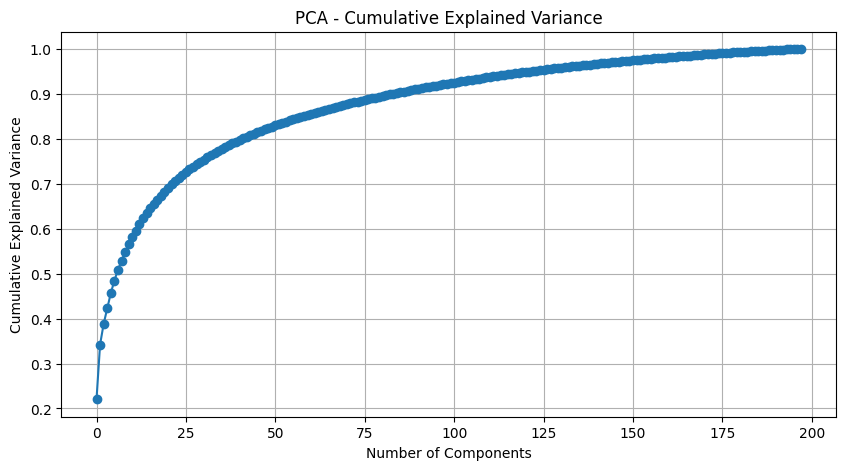

In [15]:
## Perform PCA

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(processed_images_reshaped)

## Plot the variance ratio

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

## 2.3 Data in 2d

unique_labes ['Gaeul' 'Leeseo' 'Liz' 'Rei' 'Wonyoung' 'Yujin']


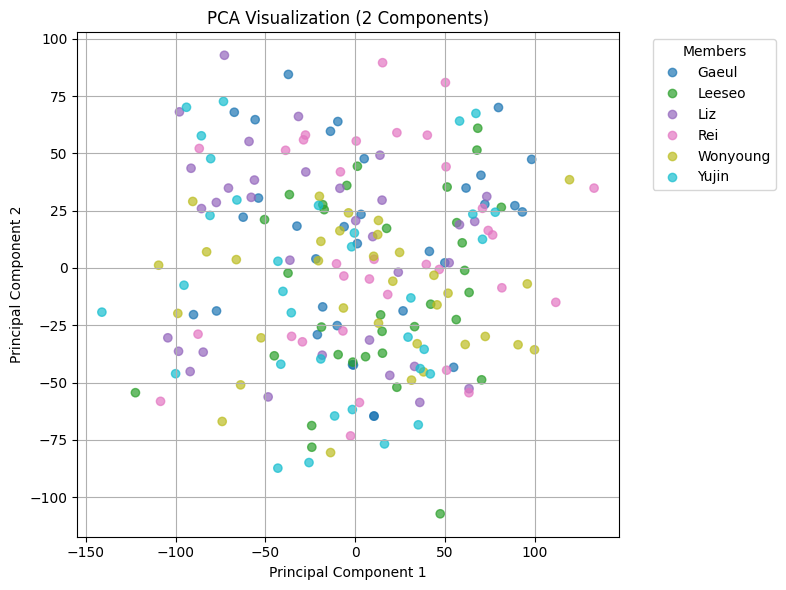

In [32]:
## Visualize Data in 2D

### Create a new PCA object

pca_2d = PCA(n_components=2)

images_2d = pca_2d.fit_transform(processed_images_reshaped)

### Look the clusters

plt.figure(figsize=(8, 6))

# Scatter plot (colors by encoded_labels)
scatter = plt.scatter(images_2d[:, 0], images_2d[:, 1], c=encoded_labels, cmap='tab10', alpha=0.7)
unique_labes = np.unique(labels)
print('unique_labes', unique_labes)

# Legend: match handles to class names
handles, _ = scatter.legend_elements()
plt.legend(handles = handles,
           labels=unique_labels,
           title="Members",
           bbox_to_anchor=(1.05, 1),
           loc='upper left')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization (2 Components)")
plt.grid(True)
plt.tight_layout()
plt.show()